Nama : Diggy Bani Nusantara; Kelas : Belajar Machine Learning Untuk Pemula; No. Registrasi : 1494037162101-336; Program : FGA; Klasifikasi Genre Film;

In [1]:
#Library
from google.colab import files 
import pandas as pd
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [3]:
!pip install -q Kaggle

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lokkagle/movie-genre-data
!unzip movie-genre-data.zip -d train

#Link Dataset https://www.kaggle.com/lokkagle/movie-genre-data
df = pd.read_csv("/content/train/kaggle_movie_train.csv")
df.head()

#Jumlah Dataset Genre
df['genre'].value_counts()

df = df[~df['genre'].isin(['drama','thriller','other','adventure','romance'])]
df['genre'].value_counts()

Saving kaggle.json to kaggle (1).json
movie-genre-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movie-genre-data.zip
replace train/kaggle_movie_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/kaggle_movie_train.csv  


comedy    2941
action    2392
sci-fi     613
horror     456
Name: genre, dtype: int64

In [4]:
#Preprocessing
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))

df = df.drop(['id', 'text'], axis=1)
df.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


In [5]:
#Label Genre Categorical
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

text = df_genre['Text'].astype(str)
label = df_genre[['comedy', 'action','sci-fi','horror']].values

#Split Validation 20%
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

In [6]:
#Tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sequens_train = tokenizer.texts_to_sequences(genre_train)
sequens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sequens_train) 
padded_test = pad_sequences(sequens_test)

In [7]:
#Sequential, LSTM, Embedding
model = Sequential([
        Embedding(input_dim=5000, output_dim=16),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
])

In [8]:
#Compile
Adam(learning_rate=0.000128, name='adam')
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

#Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi Sudah Lebih 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [9]:
num_epochs = 30
history = model.fit(
    padded_train,
    label_train,
    epochs=num_epochs,
    validation_data=(padded_test, label_test),
    verbose=2,
    callbacks=[callbacks])

Epoch 1/30
161/161 - 11s - loss: 1.1823 - accuracy: 0.4165 - val_loss: 1.1158 - val_accuracy: 0.4645 - 11s/epoch - 70ms/step
Epoch 2/30
161/161 - 2s - loss: 0.9825 - accuracy: 0.5675 - val_loss: 0.7528 - val_accuracy: 0.7377 - 2s/epoch - 10ms/step
Epoch 3/30
161/161 - 2s - loss: 0.9096 - accuracy: 0.6434 - val_loss: 0.8171 - val_accuracy: 0.7049 - 2s/epoch - 11ms/step
Epoch 4/30
161/161 - 2s - loss: 0.5363 - accuracy: 0.8004 - val_loss: 0.5271 - val_accuracy: 0.8087 - 2s/epoch - 11ms/step
Epoch 5/30
161/161 - 2s - loss: 0.3870 - accuracy: 0.8600 - val_loss: 0.5029 - val_accuracy: 0.8158 - 2s/epoch - 11ms/step
Epoch 6/30
161/161 - 2s - loss: 0.2524 - accuracy: 0.8920 - val_loss: 0.4634 - val_accuracy: 0.8165 - 2s/epoch - 14ms/step
Epoch 7/30
161/161 - 2s - loss: 0.2235 - accuracy: 0.9035 - val_loss: 0.4103 - val_accuracy: 0.8626 - 2s/epoch - 12ms/step
Epoch 8/30
161/161 - 2s - loss: 0.1633 - accuracy: 0.9194 - val_loss: 0.4591 - val_accuracy: 0.8634 - 2s/epoch - 11ms/step
Epoch 9/30
161

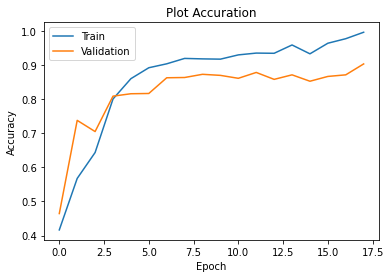

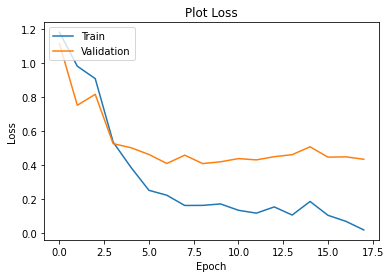

In [10]:
#Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot Accuration')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()